__Websites__<br>
    preprocessing methods outline - https://blog.ml.cmu.edu/2020/08/31/2-data-exploration/<br>
    outliers simple - https://analyticsindiamag.com/how-to-detect-and-treat-outliers-in-categorical-data/<br>
    pca collinearity removal/heatmap - https://towardsdatascience.com/how-do-you-apply-pca-to-logistic-regression-to-remove-multicollinearity-10b7f8e89f9b#:~:text=PCA%20in%20action%20to%20remove%20multicollinearity&text=PCA%20(Principal%20Component%20Analysis)%20takes,effectively%20eliminate%20multicollinearity%20between%20features.<br>
    vif - https://towardsdatascience.com/how-to-remove-multicollinearity-using-python-4da8d9d8abb2<br>
    pca 2D - https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51<br>
    pca 3D - https://drzinph.com/pca-visualized-with-3d-scatter-plots/<br>
    tsne -https://builtin.com/data-science/tsne-python<br>
    umap - https://blog.ml.cmu.edu/2020/08/31/2-data-exploration/<br>
    automatic outlier detection - https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/<br>
    3D t-sne and umap -  https://plotly.com/python/t-sne-and-umap-projections/#project-data-into-3d-with-tsne-and-pxscatter3d<br>
    knn - https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f<br>
    hyperparameter tuning - https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74<br>
    model evaluation - https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b<br>
    pydot and graphviz - https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Random%20Forest%20Explained.ipynb<br>

    To do:
    -Explore hyperparameter tuning time and accuracy graphs
    -Compare metrics of models
    -evaluation models https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce

In [1]:
#sklearn imports

from sklearn import metrics, model_selection, ensemble
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, roc_auc_score

#data handling imports
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# visualisation imports
# separated to reduce import time

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import umap.umap_ as umap

from statsmodels.stats.outliers_influence import variance_inflation_factor

import plotly.express as px

import pydot

from mlxtend.plotting import plot_decision_regions

import time

c:\Users\Kai Heale\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__Preprocessing and Data Exploration__<br>
We want to predict edibility<br>
It can take values edible, poisonous or unknown. Unknown and poisonous are grouped together

First read the file and format it as desired

Missing values are stored as '?' characters so we convert to NaN to make the data easier to process

In [3]:
#cell to read raw data

#read contents of data file
file = pd.read_csv("agaricus-lepiota.data", header = None)

# create list to be used as headers
features = ['edibility', 'capShape', 'capSurface', 'capColor', 'bruises', 'odor', 
            'gillAttachment', 'gillSpacing', 'gillSize', 'gillColor', 
            'stalkShape', 'stalkRoot', 'stalkSurfaceAboveRing', 'stalkSurfaceBelowRing', 
            'stalkColorAboveRing', 'stalkColorBelowRing', 'veilType', 'veilColor', 
            'ringNumber', 'ringType', 'sporePrintColor', 'population', 'habitat']

#convert '?' to NaN
file.replace({'?': np.nan}, inplace=True)

#converting data frame to csv
file.to_csv("Data/agaricus-lepiota.csv", header=features, index=False)

data = pd.read_csv("Data/agaricus-lepiota.csv")

#result = data.head(10)
#print(data)
#print(result)

Simple data exploration for illustration<br>
Shows that the only feature containing missing values is 'stalkRoot', with 2480 null values

It's impractical to perform univariate analysis on every single feature due to the high dimensionality, but we can at least illustrate some

In [ ]:
print(data.head(5)) # print first 5 rows
print(data.shape) # number of rows and columns
print(data.info()) # data types of each feature
print(data.isnull().sum()) # show how many NaN values in each feature

sns.set_theme(style="whitegrid")

# show even split of values in the feature to be predicted
data['edibility'] = LabelEncoder().fit_transform(data['edibility'])
fig = plt.figure(figsize=(7,5))
sns.countplot(x=data['edibility'])
plt.xlabel("Count")
plt.ylabel("Edibility")
plt.title("Countplot to Show number of Edible (0) and Poisonous (1) data points")
fig.savefig("Images/Edibility Countplot.png")

# this visualisation works best for features with a wide range of possible values
# chose 3 features as a starting point

f = plt.figure(figsize=(15,5))
f.add_subplot(1,3,1)
sns.countplot(x = data['population'])
sns.color_palette("pastel")
f.add_subplot(1,3,2)
sns.countplot(x = data['ringNumber'])
sns.color_palette("pastel")
f.add_subplot(1,3,3)
sns.countplot(x=data['gillColor'])
sns.color_palette("pastel")
f.savefig("Images/3 Countplots.png")

First need to use label encoding - OneHot encoding not applicable due to the high dimensionality of the dataset. OneHot Encoding would require using a large amount of memory

In [4]:
#cell for encoding the data

#use label encoding on all features that are categorical
le = LabelEncoder()

for i in range(len(features)):
   try:
      data[features[i]] = le.fit_transform(data[features[i]])
   except:
      pass

data.to_csv("Data/agaricus-lepiota-encoded.csv")

In [ ]:
#violin plots to show distribution
figure, axes = plt.subplots(3,7,figsize = (30,20))
figure.suptitle("Violin Plots of feature scompared with Edibility")

graph_features = ['capShape', 'capSurface', 'capColor', 'bruises', 'odor', 
            'gillAttachment', 'gillSpacing', 'gillSize', 'gillColor', 
            'stalkShape', 'stalkRoot', 'stalkSurfaceAboveRing', 'stalkSurfaceBelowRing', 
            'stalkColorAboveRing', 'stalkColorBelowRing', 'veilColor', 
            'ringNumber', 'ringType', 'sporePrintColor', 'population', 'habitat']

count = 0
for i in range(0,3):
    for j in range(0,7):
        ax = sns.violinplot(ax = axes[i,j], data = data, x="edibility", y = graph_features[count])
        count +=1

plt.savefig("Images/Violin Plots.png")

Deletion methods of dealing with missing values<br>
**Only use one of the 2 cell below at a time**

**Don't use either if you're using the cell to predict missing values**

1. Delete any column containing missing values
2. Delete any row containing missing values

Since only one feature contains missing values (stalkRoot) method 1 is most effective as it deletes less data

In [5]:
#1.
#removes column with missing values which in our data is only stalkRoot
#one way to deal with missing values
print(data.shape)

treated_data = data.drop('stalkRoot', axis = 1).reset_index(drop=True)

features.remove("stalkRoot")
print(features)

# show how much data is lost
print(treated_data.shape)

#convert dataframe to csv
treated_data.to_csv("Data/agaricus-lepiota-no-stalkRoot.csv")

#print(data.head(10))

(8124, 23)
['edibility', 'capShape', 'capSurface', 'capColor', 'bruises', 'odor', 'gillAttachment', 'gillSpacing', 'gillSize', 'gillColor', 'stalkShape', 'stalkSurfaceAboveRing', 'stalkSurfaceBelowRing', 'stalkColorAboveRing', 'stalkColorBelowRing', 'veilType', 'veilColor', 'ringNumber', 'ringType', 'sporePrintColor', 'population', 'habitat']
(8124, 22)


In [ ]:
#2.
#removes all rows that have missing values
print(data.shape)

treated_data = data[data['stalkRoot'] != 4].reset_index(drop=True)
 
# show how much data is lost
print(treated_data.shape)

#convert dataframe to csv
treated_data.to_csv("Data/agaricus-lepiota-NaN-removed.csv")

Better way to deal with missing values: Use classifier or regressor based on values which aren't missing to predict the missing values<br>
Need to be careful to avoid overfitting (as with any predictor)

Could also set the values to some default or mean value


In [ ]:
#predict missing values for stalkRoot

#drop 'edibility' from dataframe as it will be the target feature in the later models
#It would be a bad idea to use 'edibility' to predict missing 'stalkRoot' values then use those values to later predict 'edibility'
NaN_predict = data.drop('edibility', axis = 1).reset_index(drop=True)

#split into set that contains missing values for 'stalkRoot' and set that does not contan missing values for 'stalkRoot'
#The 'NaN' values are encoded to be '4' so they are removed
NaN_train_data = NaN_predict[NaN_predict['stalkRoot']!= 4].copy()
NaN_test_data = NaN_predict[NaN_predict['stalkRoot'] == 4].copy()

#split data missing values into train and test set
NaN_X_train = NaN_train_data.drop('stalkRoot', axis = 1).reset_index(drop=True)
NaN_y_train = NaN_train_data['stalkRoot']

NaN_X_test = NaN_test_data.drop('stalkRoot', axis = 1).reset_index(drop=True)

###############################################################################################################################
#This code further breaks the data down into training and test sets comprising of rows that have no missing values
#Allows us to run models and check how accurately they can predict the missing values then choose an appropriate one
#In this case both Random Forest and Support Vector Classification predict that exact same values for 'stalkRoot' so either can be used
#Both have 100% accuracy in predicitng 'stalkRoot' so we know when we predict the missing values they will most likely be correct.

#Split data with non missing values into train and test set
X_train, X_test, y_train, y_test = train_test_split(NaN_train_data, NaN_train_data['stalkRoot'], test_size=0.2,random_state=42)

#create classes for both classification models
rfr = RandomForestClassifier()
svm = SVC()

#fit and predict both models
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

rfr_rounded = (np.rint(rfr_pred)).astype(int)

svm_rounded = (np.rint(svm_pred)).astype(int)

#create a list and append all predicted values which arent the same
different = []

for i in range(len(rfr_rounded)):
    if rfr_rounded[i] != svm_rounded[i]:
        different.append(rfr_rounded[i], svm_rounded[i])

#check how well models performed
print(len(different))

print(classification_report(y_test,rfr_rounded))

print(classification_report(y_test,svm_rounded))
##############################################################################################################################
#now this code is to predict missing values

#create random forest class
rfc = RandomForestClassifier()

#fit and predict data
rfc.fit(NaN_X_train,NaN_y_train)
y_pred = rfc.predict(NaN_X_test)

#set NaN values to be the predicted values
rounded_data = (np.rint(y_pred)).astype(int)
NaN_test_data['stalkRoot'] = rounded_data

NaN_test_data.to_csv("Data/predicted-missing-values.csv")

#combine the two dataframes to make the complete dataset
frames = [NaN_train_data, NaN_test_data]
treated_data = pd.concat(frames)
treated_data = treated_data.sort_index()
treated_data.insert(0, column = 'edibility', value = data['edibility'])

treated_data.to_csv("Data/full-data.csv")

In [6]:

#create multiple datasets which can be preprocessed differently and compared later
baseline_X = data.drop('edibility', axis = 1).reset_index(drop=True)
baseline_y = data['edibility']

X = treated_data.drop('edibility', axis = 1).reset_index(drop=True)
y = treated_data['edibility'] 

graph_labels = []
for i in y:
    if i == 0:
        graph_labels.append("Edible")
    else:
        graph_labels.append("Poisonous")

#scale the data for correct visualisation
data_scaled = StandardScaler().fit_transform(X)

Now deal with outliers<br>
We define outliers as values a category can take which is significantly more or less frequent than the others<br>

Detect outliers based on relative frequency and remove any rows containing outliers in at least one category<br>
Then show histogram of data distribution within categories containing outliers

Original dataset: (8124, 22)
Outliers removed: (7619, 22)


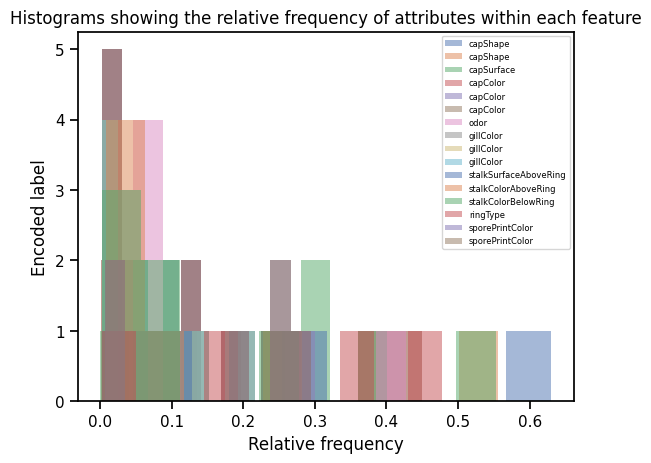

In [7]:
#cell to detect and remove outliers

#decides relative frequency threshold, below which values are considered outliers
threshold = 0.01
contains_outliers = []
outlier_features = []
num_values = data.nunique()

print("Original dataset:",treated_data.shape)

#loop through categories and identify which contain outliers according to the above definitions
for i in range(len(features)):
    if num_values[i] > 2:
        value_frequencies = treated_data[features[i]].value_counts(normalize=True) #normalize parameter converts values to relative frequency

        #loop through features that contain outliers and remove the all rows that contain the outlier values
        for j in range(len(value_frequencies)):
            if value_frequencies.iloc[j] < threshold:
                treated_data = treated_data[treated_data[features[i]] != value_frequencies.index[j]]
                contains_outliers.append(value_frequencies)
                outlier_features.append(features[i])

#print(outlier_features)
#print(contains_outliers)

print("Outliers removed:",treated_data.shape)

#now display histogram
sns.set_theme(style = None)

if len(contains_outliers) != 0:
    for x in range(len(contains_outliers)):
        outlier_histogram = plt.hist(contains_outliers[x], alpha = 0.5, label = outlier_features[x])

    plt.legend(loc='upper right',prop={'size': 6})
    plt.xlabel("Relative frequency")
    plt.ylabel("Encoded label")
    plt.title("Histograms showing the relative frequency of attributes within each feature")
    plt.savefig("Images/Frequency Histogram.png")

Now check for any features which only contain one value<br>
These won't affect the model performance so we can remove them to simplify the dataset

In [8]:
#cell to remove redundant features

num_values = treated_data.nunique()
#print(num_values)
removed_features = []


#treated_data = treated_data[treated_data[features[i]] != value_frequencies.index[j]]

j = 0
for i in range(len(features)):
    if num_values[i] == 1:
        treated_data = treated_data.drop(features[j],axis=1).reset_index(drop=True)
        removed_features.append(features[j])
        features.remove(features[j])
    else:
        j += 1

X = treated_data.drop('edibility', axis = 1).reset_index(drop=True) #update treated X
y = treated_data['edibility'] #update treated y

print("Removed",removed_features)
#print(treated_data.nunique())
#data = data.drop('veilType', axis = 1).reset_index(drop=True)
#features.remove('veilType')

Removed ['gillAttachment', 'veilType', 'veilColor']


Display heatmap to explore correlation between features<br>
Multicollinearity can lead to overfitting so need to remove correlated features

                  feature        VIF
0                capShape   5.678148
1              capSurface   3.824614
2                capColor   5.442504
3                 bruises  11.453895
4                    odor   8.412325
5             gillSpacing   4.376056
6                gillSize   6.583219
7               gillColor   6.959525
8              stalkShape   8.315213
9   stalkSurfaceAboveRing  11.471721
10  stalkSurfaceBelowRing  10.945297
11    stalkColorAboveRing  15.630686
12    stalkColorBelowRing  15.526419
13             ringNumber  53.810171
14               ringType  15.095552
15        sporePrintColor  22.174268
16             population  20.634140
17                habitat   2.868704


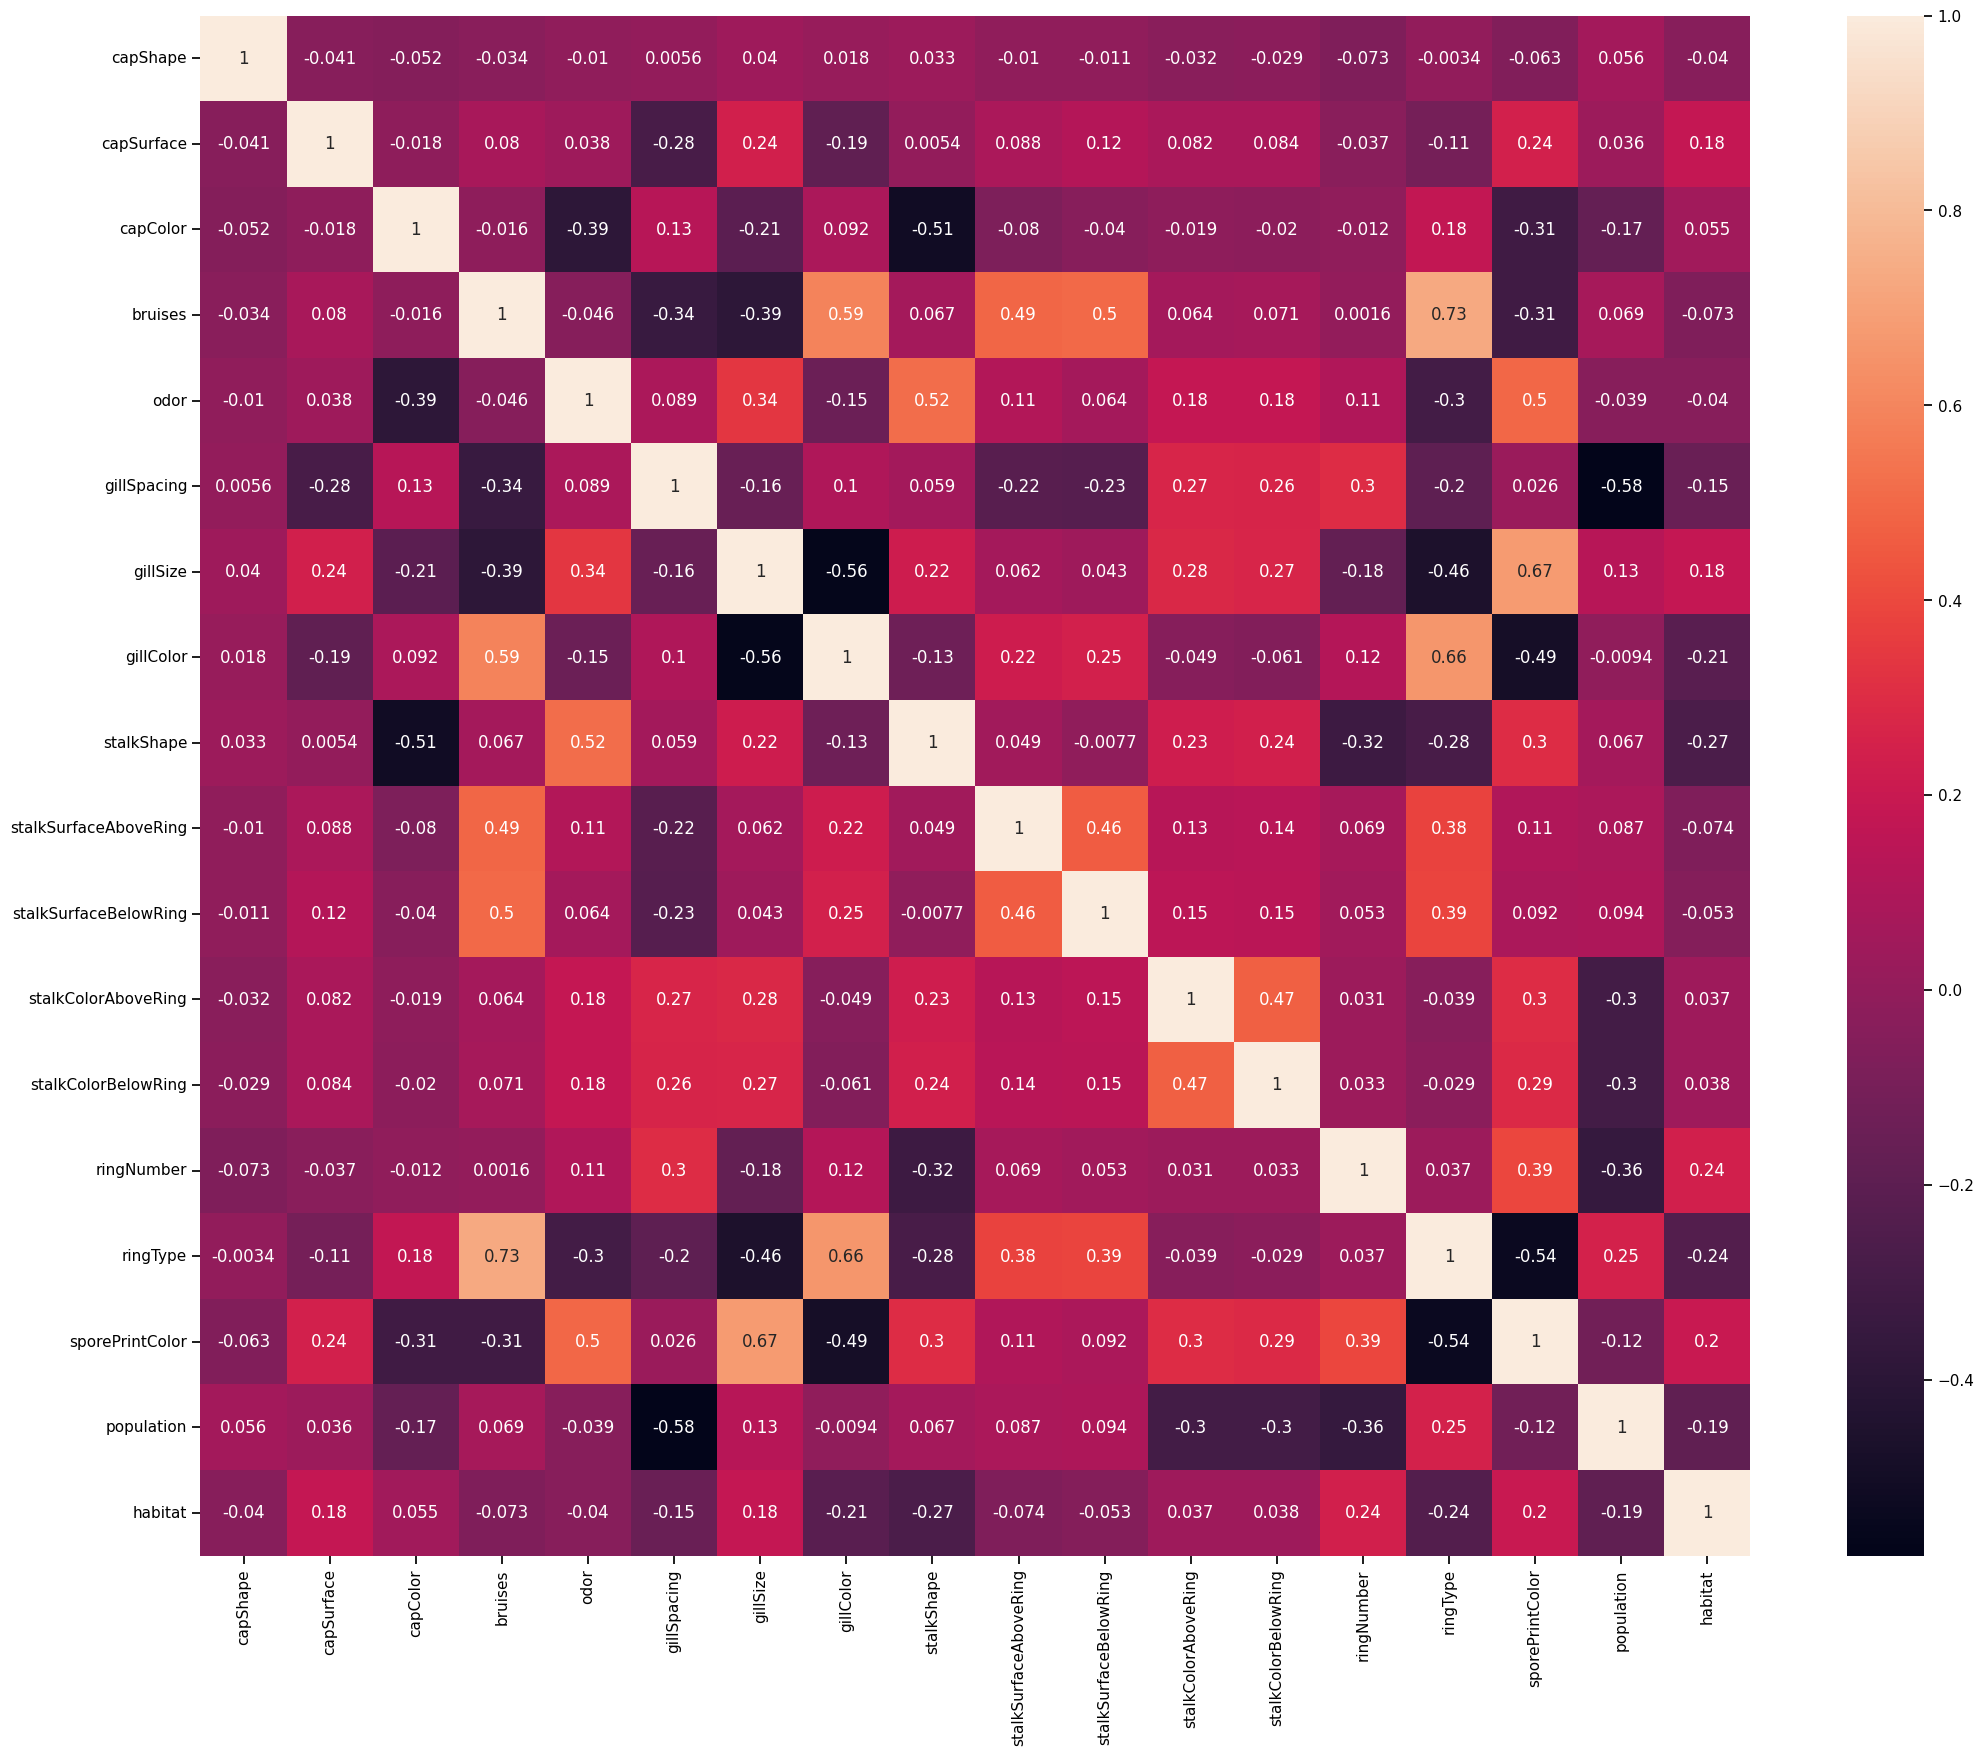

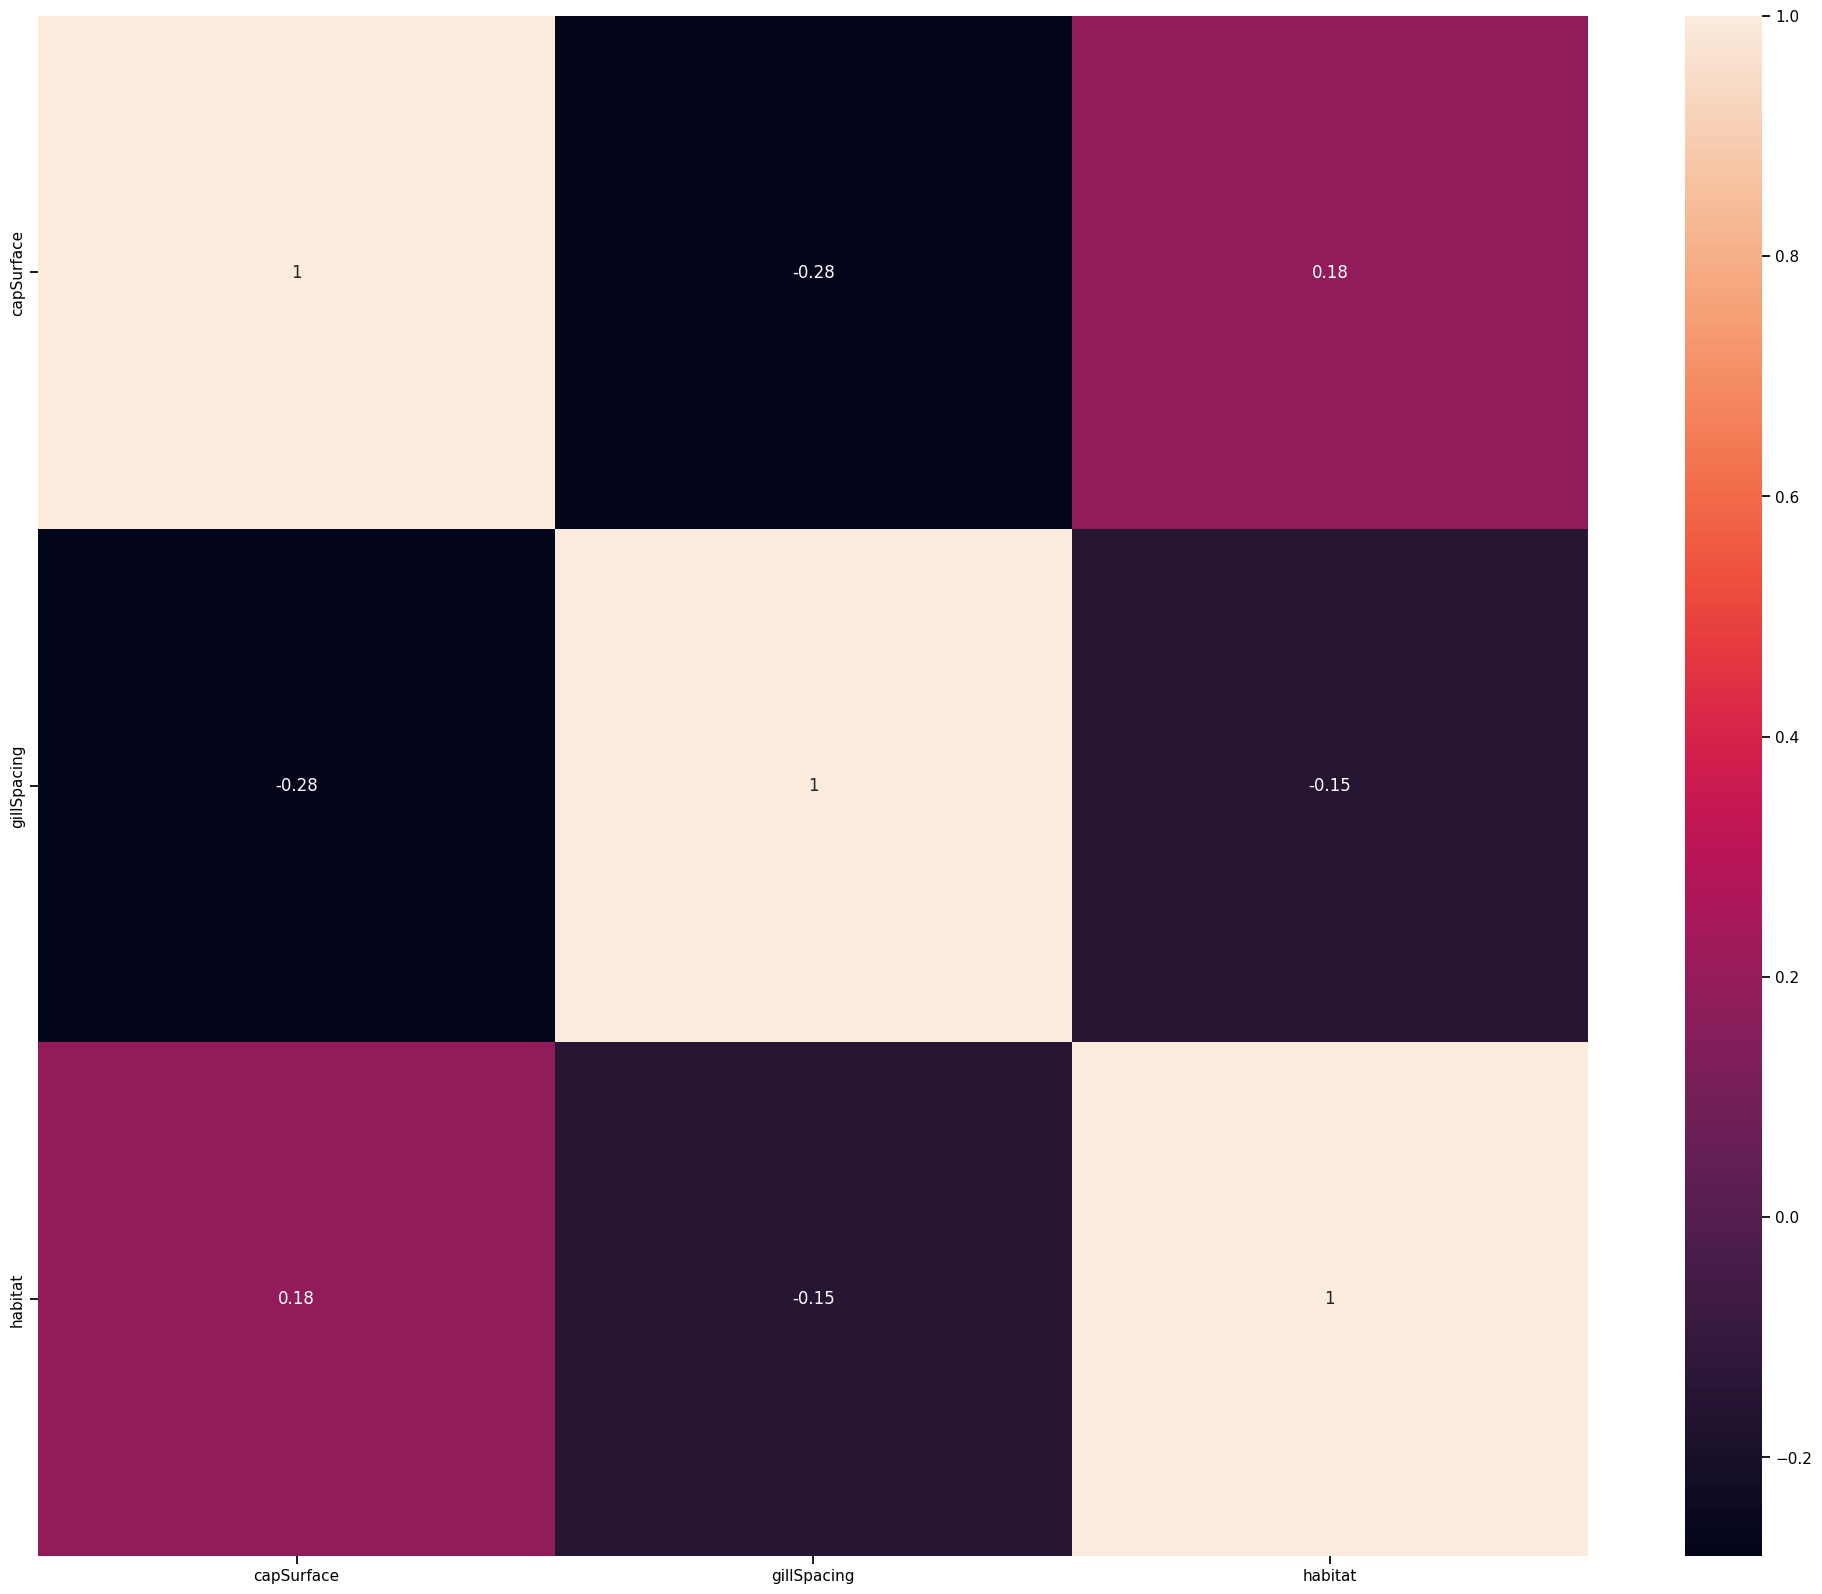

In [9]:
#cell that uses variance inflation factor to identify and remove highly correlated data

#create a heatmap showing feature correlation
fig = plt.figure(figsize=(25, 20))
sns.heatmap(X.corr(), annot=True)
plt.savefig("Images/Heatmap.png")

#as you can see from heatmap there are some features with high correlation

#create dataframe with all features and their VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data)

features_to_drop = []

#loop through the features and add those with VIF higher than 7 to a list
for i in range(len(X.columns)):
	if vif_data["VIF"][i] > 5:
		drop = vif_data["VIF"][i]
		features_to_drop.append(vif_data["feature"][i])

#create new dataframe identified features removed
uncorrelated_X = X.drop(features_to_drop, axis = 1).reset_index(drop=True)

#scale for visualisation
uncorrelated_X_scaled = StandardScaler().fit_transform(uncorrelated_X)

cleaned_features = uncorrelated_X.columns

#generally features with VIF > 5 get removed but we can experiment with slightly higher i.e > 7

#create heatmap to compare feature correlation of new dataframe
fig2 = plt.figure(figsize=(25, 20))
sns.heatmap(uncorrelated_X.corr(), annot=True)
plt.savefig("Images/Heatmap 2.png")

#as seen by second heatmap these have much less colinearality

__Data Visualisation__

1. PCA<br>
Linear method so less complex than T-SNE, meaning it takes much less time<br>
But not so useful to visualise our dataset as shown by the explained variance and scree plot<br>

However it could be useful to reduce multicollinearity instead of data visualisation<br>
Could use the first 8 pc's to get about ~90% explained variance, 9 to get ~93%, 10 to get ~95% which greatly reduces the dimesionality of out dataset while mostly maintaining important information

In [ ]:
#data visualisation pca 2D
pca = PCA(random_state=42)
pca_features = pca.fit_transform(data_scaled)

#calculate percieved variance
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(per_var)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.rcParams["figure.figsize"] = (12,8)

#to be seen on a 2D-plot we can only use PC1 and PC2 which gives us the highest explained variance but still very low
#around 19% + 12% = 31% explained variance which is bad
plt.bar(x= range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.title('Scree Plot to Show the Explained Variance of Each PC')
plt.xlabel("PCA NO.")
plt.ylabel("Explained Variance (%)")
plt.show()
plt.savefig("Images/PCA_distribution")

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

pca_df = pd.DataFrame({'pca_1': pca_features[:,0], 'pca_2': pca_features[:,1], 'Edibility': graph_labels})
print(pca_df)

#plot pca 1 and pca 2
sns.scatterplot(x = 'pca_1', y = 'pca_2', hue = 'Edibility', data = pca_df)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("2D Visualisation using PCA")
plt.show()
plt.savefig("Images/PCA/2D PCA")

In [ ]:
#PCA 3D
pca = PCA(n_components = 3, random_state=42)
pca_features = pca.fit_transform(data_scaled)

#calculate percieved variance
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(per_var)
print(pca_features)

treated_data["edibility"] = treated_data["edibility"].astype(str)

#plot PCA 3D
pca_fig = px.scatter_3d(
    pca_features, x=0, y=1, z=2,
    color=graph_labels, labels={'color': 'Edibility'},
    title = "Dimensionality reduction using PCA to visualise the dataset"
)
pca_fig.update_traces(marker_size=8)

pca_fig.update_layout(scene = dict(
                    xaxis_title='PCA 1',
                    yaxis_title='PCA 2',
                    zaxis_title='PCA 3')
)
pca_fig.show()

pca_fig.write_html("Images/PCA/PCA-3D.html")

2. T-SNE<br>
Unlike pca, it's not linear so much more complex and better for our data<br>
The result of t-sne is greatly affected by the 'perplexity' hyperparameter<br>
Try perplexity values in the range 5-100 default is 30. Higher perplexity takes longer but may be better

In [ ]:
#data visualisation t-sne 2D
n_components = 2
tsne = TSNE(n_components, perplexity=50, random_state = 42)
tsne_features = tsne.fit_transform(data_scaled)

tsne_df = pd.DataFrame({'tsne_1': tsne_features[:,0], 'tsne_2': tsne_features[:,1], 'label': treated_data['edibility']})

#plot tnse 1 and tsne 2
sns.scatterplot(x = 'tsne_1', y = 'tsne_2', hue = 'label', data = tsne_df)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("2D Visualisation using t-SNE")
plt.show()
plt.savefig("Images/t-SNE/2D t-SNE")

In [ ]:
#3D t-SNE using plotly
n_components = 3

#create t-SNE class and set hyperparameters
tsne = TSNE(n_components, perplexity=50, random_state=42)
tsne_features = tsne.fit_transform(data_scaled)

treated_data["edibility"] = treated_data["edibility"].astype(str)

#plot t-SNE
tsne_fig = px.scatter_3d(
    tsne_features, x=0, y=1, z=2,
    color=graph_labels, labels={'color': 'Edibility'},
    title = "Dimensionality reduction using t-SNE to visualise the dataset"
)
tsne_fig.update_traces(marker_size=8)

tsne_fig.update_layout(scene = dict(
                    xaxis_title='t-SNE 1',
                    yaxis_title='t-SNE 2',
                    zaxis_title='t-SNE 3')
)
tsne_fig.show()

tsne_fig.write_html("Images/t-SNE/t-SNE-3D.html")

3. UMAP <br>
UMAP works very similarly to tsne but gets more efficient for higher volumes of data <br>
Result greatly affected by n_neighbors and min_dist hyperparameters <br>
For n_neighbors try range 5-100 and min_dist 0.1-1

In [ ]:
#data visualisation UMAP

#create UMAP class and set hyperparameters
fit = umap.UMAP(
    n_neighbors=50,
    min_dist=0.25,
    n_components=2,
    metric = 'correlation',
    random_state = 42
)

umap_features = fit.fit_transform(data_scaled)

umap_df = pd.DataFrame({'umap_1': umap_features[:,0], 'umap_2': umap_features[:,1], 'Edibility': graph_labels})


#plot 2D UMAP
sns.scatterplot(x = 'umap_1', y = 'umap_2', hue = 'Edibility', data = umap_df)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("2D Visualisation using UMAP")
plt.show()
plt.savefig("Images/UMAP/2D UMAP")


In [ ]:
#UMAP 3D using plotly

#create UMAP class and set hyperparameters
fit = umap.UMAP(
    n_neighbors=75,
    min_dist=0.5,
    n_components=3,
    metric = 'correlation',
    random_state = 42
)

umap_features = fit.fit_transform(data_scaled)

treated_data["edibility"] = treated_data["edibility"].astype(str)

#plot UMAP 3D
umap_fig = px.scatter_3d(
    umap_features, x=0, y=1, z=2,
    color=graph_labels, labels={'color': 'Edibility'},
    title = "Dimensionality reduction using UMAP to visualise the dataset"
)
umap_fig.update_traces(marker_size=5)

umap_fig.update_layout(scene = dict(
                    xaxis_title='UMAP 1',
                    yaxis_title='UMAP 2',
                    zaxis_title='UMAP 3')
)

umap_fig.show()

umap_fig.write_html("Images/UMAP/UMAP-3D.html")


__Models__ 

Compare baseline data (baseline_X and baseline_y) with treated data (uncorrelated_X and y)

1. K-nearest neighbours<br>
Hyperparameter: n_neighbors<br>
Low value less accurate, high value overfits

In [ ]:
# knn hyperparameter exploration: accuracy v n_neighbors

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
neighbours = range(1,30)
accuracies = []

for i in range(len(neighbours)):
    knn = KNeighborsClassifier(n_neighbors=neighbours[i])
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(neighbours, accuracies)
plt.title("Knn accuracy as n_neighbors increases")
plt.xlabel("Num neighbours")
plt.ylabel("Accuracy")
plt.savefig("Images/KNN/Knn accuracy v n_neighbors.png")

In [ ]:
# knn hyperparameter exploration: decision regions
# plot decision regions as the accuracy changes to help explain why

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
n_neighbours = [1, 2, 5, 11, 12, 15, 25] # points on the accuracy graph with changes

for i in range(len(n_neighbours)):
    knn = KNeighborsClassifier(n_neighbors=n_neighbours[i])
    knn.fit(X_train, y_train)

    for j in range(2):
        plt.subplot(2,1,j+1)
        plot_decision_regions(X_test.values, y_test.values, clf = knn, legend = 2, feature_index = [0,2], filler_feature_values={1: j}, filler_feature_ranges={1:0.75})
        plt.title("n_neighbors="+str(n_neighbours[i])+" gillSpacing="+str(j))
        plt.xlabel("capSurface")
        plt.ylabel("habitat")
    
    plt.tight_layout()
    plt.savefig("Images/KNN/Knn Decision Regions "+str(n_neighbours[i])+".png")
    plt.close()

Fitting 3 folds for each of 100 candidates, totalling 300 fits

 {'weights': 'distance', 'p': 1, 'n_neighbors': 23, 'leaf_size': 19, 'algorithm': 'kd_tree'} 

KNeighborsClassifier(algorithm='kd_tree', leaf_size=19, n_neighbors=23, p=1,
                     weights='distance')
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


c:\Users\Kai Heale\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 8000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Kai Heale\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Kai Heale\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py", line 207, in fit
    return self._fit(X, y)
  File "c:\Users\Kai Heale\AppData\Local\Programs\Python\Python310\lib


 {'algorithm': 'kd_tree', 'leaf_size': 1, 'n_neighbors': 22, 'p': 1, 'weights': 'distance'} 

KNeighborsClassifier(algorithm='kd_tree', leaf_size=1, n_neighbors=22, p=1,
                     weights='distance')
Baseline

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       788
           1       0.86      0.79      0.83       736

    accuracy                           0.84      1524
   macro avg       0.84      0.84      0.84      1524
weighted avg       0.84      0.84      0.84      1524

[[695  93]
 [152 584]]
Random Search

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       788
           1       0.86      0.81      0.83       736

    accuracy                           0.84      1524
   macro avg       0.84      0.84      0.84      1524
weighted avg       0.84      0.84      0.84      1524

[[689  99]
 [140 596]]
Grid Search

              precision    recall  f1-score   supp

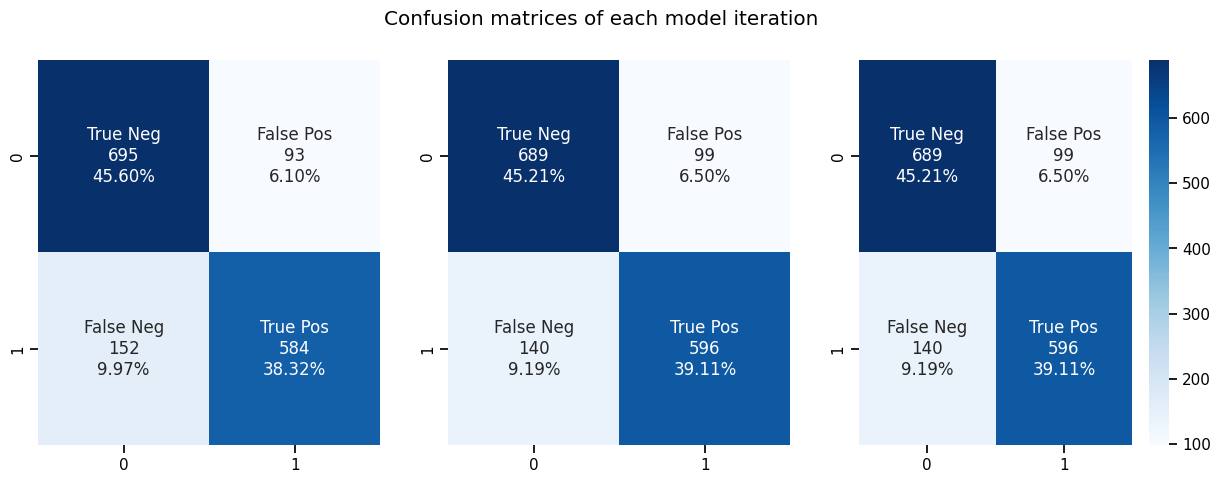

In [11]:
#cell for  knn model

# hyperparameters
n_neighbors = list(range(1,30))
weights = ['uniform','distance']
leaf_size = list(range(1,50))
p = [1,2]

# create dictionary
random_grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': ['kd_tree'],
               'leaf_size': leaf_size,
               'p': p}

# baseline model
knn_baseline = KNeighborsClassifier()

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)
knn_baseline.fit(X_train, y_train)
baseline_knn_pred = knn_baseline.predict(X_test)

# random hyperparameter values
knn_random = RandomizedSearchCV(estimator = knn_baseline, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'accuracy')

knn_random.fit(X_train, y_train)

best_random_values = knn_random.best_params_
print("\n", best_random_values, "\n")
best_random_knn = knn_random.best_estimator_
print(best_random_knn)

#predict using best random model and get model accuracy report
best_random_pred = best_random_knn.predict(X_test)

#create a refined hyperparameter grid with values close to the best random estimator to look for further optimization
# fits may fail if n_neighbors or leaf_size < 15 however they will just be skipped so this is okay
param_grid = {
    'n_neighbors': list(range((best_random_values['n_neighbors']-20),(best_random_values['n_neighbors']+20))),
    'weights': [best_random_values['weights']],
    'algorithm': ['kd_tree'],
    'leaf_size': list(range((best_random_values['leaf_size']-20),(best_random_values['leaf_size']+20))),
    'p': [best_random_values['p']]
}

knn_refined = KNeighborsClassifier()

# find the best scoring model using the refined hyperparameter grid
knn_grid = GridSearchCV(estimator = knn_refined, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

knn_grid.fit(X_train, y_train)

print("\n", knn_grid.best_params_, "\n")
best_grid_knn = knn_grid.best_estimator_
print(best_grid_knn)

# predict with refined model
best_refined_pred = best_grid_knn.predict(X_test)

figure, axes = plt.subplots(1,3,figsize = (15,5))
figure.suptitle("Confusion matrices of each model iteration")

cf_matrix = confusion_matrix(y_test, baseline_knn_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#show model accuracy report
print("Baseline\n")
print(classification_report(y_test,baseline_knn_pred))

print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot = labels,fmt = '', cmap = 'Blues', ax = axes[0], cbar = False)

print("Random Search\n")
print(classification_report(y_test,best_random_pred))

cf_matrix_2 = confusion_matrix(y_test, best_random_pred)

print(cf_matrix_2)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_2.flatten()/np.sum(cf_matrix_2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_2, annot = labels,fmt = '', cmap = 'Blues', ax = axes[1],cbar = False)

print("Grid Search\n")
print(classification_report(y_test,best_refined_pred))

cf_matrix_3 = confusion_matrix(y_test, best_refined_pred)

print(cf_matrix_3)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_3.flatten()/np.sum(cf_matrix_3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_3, annot = labels,fmt = '', cmap = 'Blues', ax = axes[2])

plt.savefig("Images/KNN/Confusion Matrix.png")

In [ ]:
# RFC n_estimators hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

n_estimators = [1,2,5,10,20,50,100,200,400,600,800,1000]

for n_estimator in n_estimators:
    rfc_n_estimator = RandomForestClassifier(n_estimators= n_estimator, random_state = 42)
    rfc_n_estimator.fit(X_train,y_train)

    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = rfc_n_estimator, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "n_estimators = " + str(n_estimator) + " gillSpacing="+str(i)
        print(title)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    image_directory = "Images/RFC/RFC Regions/n_estimators = " + str(n_estimator) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.close()

In [ ]:
# RFC max_depth hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

max_depths = [1,2,5,10,20,50,100,200]

for max_depth in max_depths:
    rfc_max_depth = RandomForestClassifier(max_depth= max_depth, random_state = 42)
    rfc_max_depth.fit(X_train,y_train)

    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = rfc_max_depth, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "max_depth = " + str(max_depth) + " gillSpacing="+str(i)
        print(title)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    image_directory = "Images/RFC/RFC Regions/max_depth = " + str(max_depth) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.close()

In [ ]:
# RFC min_samples_split hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

min_samples_splits = [2,5,10,20,50,100,200]

for min_samples_split in min_samples_splits:
    rfc_min_samples_split = RandomForestClassifier(min_samples_split= min_samples_split, random_state = 42)
    rfc_min_samples_split.fit(X_train,y_train)

    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = rfc_min_samples_split, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "min_samples_split = " + str(min_samples_split) + " gillSpacing="+str(i)
        print(title)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    image_directory = "Images/RFC/RFC Regions/min_samples_split = " + str(min_samples_split) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.close()

In [ ]:
# RFC min_samples_leaf hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

min_samples_leaves = [2,5,10,20,50,100,200]

for min_samples_leaf in min_samples_leaves:
    rfc_min_samples_leaf = RandomForestClassifier(min_samples_leaf= min_samples_leaf, random_state = 42)
    rfc_min_samples_leaf.fit(X_train,y_train)

    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = rfc_min_samples_leaf, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "min_samples_leaf = " + str(min_samples_leaf) + " gillSpacing="+str(i)
        print(title)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    image_directory = "Images/RFC/RFC Regions/min_samples_leaf = " + str(min_samples_leaf) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.close()

In [ ]:
# RFC hyperparameter exploration: accuracy and time vs n_estimators

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
n_estimators = range(1,1000)
times = []
accuracies = []

for i in range(len(n_estimators)):
    print(i)
    start_time = time.time()
    rfc = RandomForestClassifier(n_estimators=n_estimators[i])
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against n_estimators")

ax = sns.lineplot(x = n_estimators, y = accuracies, ax = axes[0])
ax.set(xlabel='n_esimators', ylabel='Accuracy')
ax2 = sns.lineplot(x = n_estimators, y = times, ax = axes[1])
ax2.set(xlabel='n_estimators', ylabel='Time (s)')
plt.savefig("Images/RFC/RFC accuracy and time vs n_estimators.png")

In [ ]:
#cell for RandomForestClassifier

#create distribution of chosen hyperparamaters to be used in random search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [3, 5, 10]
min_samples_leaf = [2, 4, 6]
bootstrap = [True, False]

#create dictionary with distribution of chosen hyperparameters
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#basline model to compare to when optimising
rf = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

baseline_rfc = RandomForestClassifier(random_state = 42, n_estimators = 10)

baseline_rfc.fit(X_train, y_train)
baseline_rfc_pred = baseline_rfc.predict(X_test)


#find best scoring random hyperparameter combination
rfc_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'accuracy')

rfc_random.fit(X_train, y_train)
best_random_values = rfc_random.best_params_

print("\n", rfc_random.best_params_, "\n")
best_random_rfc = rfc_random.best_estimator_
print(best_random_rfc)

#predict using best random model and get model accuracy report
best_pred = best_random_rfc.predict(X_test)

#create a refined hyperparameter grid with values close to the best random estimator to look for further optimization
param_grid = {
    'n_estimators': list(range((best_random_values['n_estimators']-20),(best_random_values['n_estimators']+20))),
    'max_features': [best_random_values['max_features']],
    'max_depth': list(range((best_random_values['max_depth']-9),(best_random_values['max_depth']+10))),
    'min_samples_split': list(range((best_random_values['min_samples_split']-1),(best_random_values['min_samples_split']+1))),
    'min_samples_split': list(range((best_random_values['min_samples_leaf']-1),(best_random_values['min_samples_leaf']+1))),
    'bootstrap': [best_random_values['bootstrap']]
}

rf2 = RandomForestClassifier()

#find the best scoring model using the refined hyperparameter grid
rfc_grid = GridSearchCV(estimator = rf2, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

rfc_grid.fit(X_train, y_train)

print("\n", rfc_grid.best_params_, "\n")
best_grid_rf = rfc_grid.best_estimator_
print(best_grid_rf)

#predict values using this model and show accuracy to compare models later
best_pred2 = best_grid_rf.predict(X_test)

figure, axes = plt.subplots(1,3,figsize = (15,5))
figure.suptitle("Confusion matrices of each model iteration")

cf_matrix = confusion_matrix(y_test, baseline_rfc_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


#show model accuracy report
print("Baseline\n")
print(classification_report(y_test,baseline_rfc_pred))

print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot = labels,fmt = '', cmap = 'Blues', ax = axes[0], cbar = False)

print("Random Search\n")
print(classification_report(y_test,best_pred))

cf_matrix_2 = confusion_matrix(y_test, best_pred)

print(cf_matrix_2)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_2.flatten()/np.sum(cf_matrix_2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_2, annot = labels,fmt = '', cmap = 'Blues', ax = axes[1],cbar = False)

print("Grid Search\n")
print(classification_report(y_test,best_pred2))

cf_matrix_3 = confusion_matrix(y_test, best_pred2)

print(cf_matrix_3)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_3.flatten()/np.sum(cf_matrix_3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_3, annot = labels,fmt = '', cmap = 'Blues', ax = axes[2], cbar = False)
plt.savefig("Images/RFC/Confusion Matrix.png")

#get one tree from estimators
tree = best_grid_rf.estimators_[5]

#Export the image to a dot file then use file to creat a graph
export_graphviz(tree, out_file = 'tree.dot', feature_names = cleaned_features, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('Images/tree.png')

In [ ]:
# SVC gamma hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

gammas = [0.1,1,10,100]

for gamma in gammas:
    svc_gamma = SVC(gamma = gamma, random_state = 42)
    svc_gamma.fit(X_train,y_train)

    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = svc_gamma, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "gamma = " + str(gamma) + " gillSpacing="+str(i)
        print(title)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    image_directory = "Images/SVC/SVC Regions/gamma = " + str(gamma) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.close()

In [ ]:
# SVC kernels hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

kernels = ['rbf', 'poly', 'linear']

for kernel in kernels:
    svc_kernel = SVC(kernel = kernel, random_state = 42)
    svc_kernel.fit(X_train,y_train)

    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = svc_kernel, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "kernel = " + str(kernel) + " gillSpacing="+str(i)
        print(title)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    image_directory = "Images/SVC/SVC Regions/kernel = " + str(kernel) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.close()

In [ ]:
# SVC C hyperparameter exploration

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

cs = [0.1,1,10,100]

for c in cs:
    svc_c = SVC(C = c, random_state = 42)
    svc_c.fit(X_train,y_train)

    for i in range(2):
        plt.subplot(2,1,i+1)
        plot_decision_regions(X_test.values, y_test.values, clf = svc_c, legend = 2, feature_index = [0,2], filler_feature_values={1: i}, filler_feature_ranges={1:0.75})
        title = "C = " + str(c) + " gillSpacing="+str(i)
        print(title)
        plt.title(title)
        plt.xlabel("capSurface")
        plt.ylabel("habitat")

    image_directory = "Images/SVC/SVC Regions/C = " + str(c) + ".png"
    print(image_directory)
    plt.tight_layout()
    plt.savefig(image_directory)
    plt.close()

In [ ]:
# SVC hyperparameter exploration: accuracy and time vs C

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
c = range(1,100)
accuracies = []
times = []

for i in range(len(c)):
    svc = SVC(C=c[i])
    start_time = time.time()
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    end_time = time.time()
    times.append(end_time - start_time)
    accuracies.append(accuracy_score(y_test, y_pred))

print(times)

figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against C")

ax = sns.lineplot(x = c, y = accuracies, ax = axes[0])
ax.set(xlabel='C', ylabel='Accuracy')
ax2 = sns.lineplot(x = c, y = times, ax = axes[1])
ax2.set(xlabel='C', ylabel='Time (s)')
plt.savefig("Images/SVC/SVC accuracy and time vs C.png")

In [ ]:
# SVC hyperparameter exploration: accuracy and time vs gamma

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2, random_state=42)
gamma = range(1,100)
times = []
accuracies = []

for i in range(len(gamma)):
    start_time = time.time()
    svc = SVC(gamma= gamma[i])
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    end_time = time.time()
    accuracies.append(accuracy_score(y_test, y_pred))
    times.append(end_time - start_time)

figure, axes = plt.subplots(1,2,figsize = (12,6))
figure.suptitle("Accuracy and Time Plots against Gamma")

ax = sns.lineplot(x = gamma, y = accuracies, ax = axes[0])
ax.set(xlabel='Gamma', ylabel='Accuracy')
ax2 = sns.lineplot(x = gamma, y = times, ax = axes[1])
ax2.set(xlabel='Gamma', ylabel='Time (s)')
plt.savefig("Images/SVC/SVC accuracy and time vs gamma.png")

In [ ]:
#cell for SVC

#create distribution of chosen hyperparamaters to be used in SVC
gamma = [2,5,10,20,50,100]
kernel = ['linear', 'rbf']
c = [2,5,10,20,50,100]

#create dictionary with distribution of chosen hyperparameters
random_grid = {'gamma': gamma,
               'kernel': kernel,
               'C': c,
}

print(random_grid)

#basline model to compare to when optimising
svc = SVC(random_state=42,)

X_train, X_test, y_train, y_test = train_test_split(uncorrelated_X, y, test_size=0.2)

baseline_SVC = SVC(random_state = 42)

baseline_SVC.fit(X_train, y_train)
baseline_SVC_pred = baseline_SVC.predict(X_test)

#find best scoring random hyperparameter combination
SVC_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'accuracy')

SVC_random.fit(X_train, y_train)
best_random_values = SVC_random.best_params_

print("\n", SVC_random.best_params_, "\n")
best_random_SVC = SVC_random.best_estimator_
print(best_random_SVC)

#predict using best random model and get model accuracy report
best_pred = best_random_SVC.predict(X_test)

#create a refined hyperparameter grid with values close to the best random estimator to look for further optimization

param_grid = {
    'gamma': list(range((best_random_values['gamma']-1),(best_random_values['gamma']+1))),
    'kernel': [best_random_values['kernel']],
    'C': list(range((best_random_values['C']-1),(best_random_values['C']+1))),
}

svc2 = SVC(random_state = 42)

#find the best scoring model using the refined hyperparameter grid
svc_grid = GridSearchCV(estimator = svc2, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1, scoring = 'accuracy')

svc_grid.fit(X_train, y_train)

print("\n", svc_grid.best_params_, "\n")
best_grid_svc = svc_grid.best_estimator_
print(best_grid_svc)

#predict values using this model and show accuracy to compare models later
best_pred2 = best_grid_svc.predict(X_test)

print("\n", svc_grid.best_params_, "\n")
best_grid_svc = svc_grid.best_estimator_
print(best_grid_svc)

#predict values using this model and show accuracy to compare models later
best_pred2 = best_grid_svc.predict(X_test)

figure, axes = plt.subplots(1,3,figsize = (15,5))
figure.suptitle("Confusion matrices of each model iteration")

cf_matrix = confusion_matrix(y_test, baseline_SVC_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

#show model accuracy report
print("Baseline\n")
print(classification_report(y_test,baseline_SVC_pred))

print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot = labels,fmt = '', cmap = 'Blues', ax = axes[0], cbar = False)

print("Random Search\n")
print(classification_report(y_test,best_pred))

cf_matrix_2 = confusion_matrix(y_test, best_pred)

print(cf_matrix_2)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_2.flatten()/np.sum(cf_matrix_2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_2, annot = labels,fmt = '', cmap = 'Blues', ax = axes[1],cbar = False)

print("Grid Search\n")
print(classification_report(y_test,best_pred2))

cf_matrix_3 = confusion_matrix(y_test, best_pred2)

print(cf_matrix_3)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_3.flatten()/np.sum(cf_matrix_3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_3, annot = labels,fmt = '', cmap = 'Blues', ax = axes[2])

plt.savefig("Images/SVC/Confusion Matrix.png")

In [ ]:
#prediction probabilities
r_probs_roc = [0 for _ in range(len(y_test))]
knn_probs_roc = best_grid_knn.predict_proba(X_test)
rf_probs_roc = best_grid_rf.predict_proba(X_test)
svc_probs_roc = best_grid_svc.decision_function(X_test)

#remove negative values
rf_probs_roc = rf_probs_roc[:, 1]
knn_probs_roc = knn_probs_roc[:, 1]


In [ ]:

r_auc = roc_auc_score(y_test, r_probs_roc)
knn_auc = roc_auc_score(y_test, knn_probs_roc)
rf_auc = roc_auc_score(y_test, rf_probs_roc)
svc_auc = roc_auc_score(y_test, svc_probs_roc)


r_fpr, r_tpr, _ = roc_curve(y_test, r_probs_roc)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs_roc)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs_roc)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs_roc)


plt.figure(figsize=(5, 5), dpi=100)

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN (AUROC = %0.3f)' % knn_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVM (auc = %0.3f)' % svc_auc)

plt.title("ROC Curves for the algorithms")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()

plt.savefig("Images/ROC/ROC Curves")